In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from IPython.display import Image
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, f1_score, precision_score
from sklearn.linear_model import LinearRegression
from sklearn import svm
import xgboost as xgb
# Make output directory
if not os.path.exists("output/") : os.mkdir("output/")

In [2]:
class LogisticRegression(object):

    def __init__(self, eta=0.01, n_epoch=100, random_state=1):
        self.eta = eta
        self.n_epoch = n_epoch
        self.random_state = random_state
    
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_epoch):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = self.loss(output, y)
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def loss(self, output, y):
        """Calculate loss"""
        # TODO
        error = (y - output)
        cost = (error**2).sum()/2.0
        return cost
    
    def activation(self, z):
        """Compute logistic sigmoid activation"""
        # TODO
        return 1/(1+np.exp(-z))

    def predict(self, X):
        """Return class label after unit step"""
        # TODO
        return np.where(self.activation(self.net_input(X)) > 0.5, 1, 0)

In [3]:
#load the data
data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/'
                   'arrhythmia/arrhythmia.data', header=None, sep=',', engine='python')
display(data)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279
0,75,0,190,80,91,193,371,174,121,-16,13,64,-2,?,63,0,52,44,0,0,32,0,0,0,0,0,0,0,44,20,36,0,28,0,0,0,0,0,0,52,...,0.0,8.4,-10.0,0.0,0.0,0.6,5.9,-3.9,52.7,-0.3,0.0,15.2,-8.4,0.0,0.0,0.9,5.1,17.7,70.7,-0.4,0.0,13.5,-4.0,0.0,0.0,0.9,3.9,25.5,62.9,-0.3,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,37,-17,31,?,53,0,48,0,0,0,24,0,0,0,0,0,0,0,64,0,0,0,24,0,0,0,0,0,0,32,...,0.0,5.8,-7.7,0.0,0.0,0.9,3.8,-5.7,27.7,-0.2,0.0,9.5,-5.0,0.0,0.0,0.5,2.6,11.8,34.6,-0.4,0.0,11.0,-2.4,0.0,0.0,0.4,2.6,21.6,43.4,-0.5,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,34,70,66,23,75,0,40,80,0,0,24,0,0,0,0,0,0,20,56,52,0,0,40,0,0,0,0,0,0,28,...,0.0,5.8,-4.1,4.0,-0.5,0.4,0.3,20.4,23.3,0.7,0.0,10.0,-5.7,0.0,0.0,0.5,2.2,-3.0,20.7,1.3,0.0,11.1,-3.4,0.0,0.0,0.4,3.4,11.5,48.2,0.9,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,10
3,55,0,175,94,100,202,380,179,143,28,11,-5,20,?,71,0,72,20,0,0,48,0,0,0,0,0,0,0,64,36,0,0,36,0,0,0,0,0,0,20,...,0.0,9.0,-7.9,0.0,0.0,0.1,4.1,7.6,51.0,0.4,0.0,15.0,-5.5,0.0,0.0,0.1,3.3,28.8,63.1,0.1,0.0,15.2,-3.7,0.0,0.0,0.6,3.0,36.8,68.0,0.1,0.0,12.2,-2.2,0.0,0.0,0.4,2.6,34.6,61.6,1
4,75,0,190,80,88,181,360,177,103,-16,13,61,3,?,?,0,48,40,0,0,28,0,0,0,0,0,0,0,40,24,0,0,24,0,0,0,0,0,0,52,...,0.0,8.5,-10.2,0.0,0.0,-1.0,4.7,-4.0,43.0,-0.2,0.0,15.2,-7.8,0.0,0.0,-0.1,4.9,16.2,63.2,-0.2,0.0,9.1,-0.9,0.0,0.0,-0.2,2.9,21.7,48.9,-0.4,0.0,13.1,-3.6,0.0,0.0,-0.1,3.9,25.4,62.8,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,53,1,160,70,80,199,382,154,117,-37,4,40,-27,?,63,0,52,24,0,0,28,0,0,0,0,0,0,0,44,40,0,0,32,0,0,0,0,0,0,0,...,0.0,1.3,-9.2,0.0,0.0,-0.1,2.2,-22.1,3.8,0.2,0.0,2.9,-10.3,0.0,0.0,0.8,1.4,-20.1,-9.5,0.1,0.0,4.1,-8.3,0.0,0.0,0.8,1.0,-8.4,-0.6,0.0,0.0,4.3,-5.0,0.0,0.0,0.7,0.6,-4.4,-0.5,1
448,37,0,190,85,100,137,361,201,73,86,66,52,79,?,73,0,44,36,0,0,24,0,0,0,0,0,0,0,56,0,0,0,32,0,0,0,0,0,0,0,...,0.0,12.2,-5.4,0.0,0.0,-0.3,10.8,27.7,137.8,0.1,0.0,22.5,-3.5,0.9,0.0,0.7,5.9,69.2,129.3,-0.7,0.0,21.2,-2.8,0.0,0.0,0.4,3.7,50.7,82.5,-0.5,0.0,15.6,-1.6,0.0,0.0,0.4,2.4,38.0,62.4,10
449,36,0,166,68,108,176,365,194,116,-85,-19,-61,-70,84,84,16,40,40,0,0,40,0,0,0,0,0,0,0,40,56,0,0,32,0,0,0,0,0,0,0,...,0.0,18.3,-34.1,0.0,0.0,1.4,-8.2,-75.7,-146.2,-0.4,0.0,20.6,-36.7,0.0,0.0,1.0,-8.2,-71.2,-161.4,0.2,0.0,22.0,-30.8,0.0,0.0,1.9,-2.5,-39.6,-63.6,1.2,0.0,16.3,-28.6,0.0,0.0,1.5,1.0,-44.2,-33.2,2
450,32,1,155,55,93,106,386,218,63,54,29,-22,43,103,80,0,56,0,0,0,32,0,0,0,0,0,0,16,64,0,0,0,40,0,0,0,0,0,0,16,...,0.0,8.8,-7.7,0.0,0.0,0.9,7.3,3.9,94.4,0.4,0.0,11.9,-6.7,0.0,0.0,0.6,3.8,17.5,56.2,0.1,0.0,15.3,-3.5,0.0,0.0,0.4,3.2,29.7,61.0,0.2,-0.4,12.0,-0.7,0.0,0.0,0.5,2.4,25.0,46.6,1


In [4]:
print('%d rows and %d columns' % (data.shape[0],data.shape[1]))

452 rows and 280 columns


In [5]:
np.unique(data[len(data.columns)-1])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 14, 15, 16])

In [6]:
data['arrhythmia'] = data[len(data.columns)-1].map(lambda x: 0 if x==1 else 1)
data = data.drop(len(data.columns)-2, axis=1)

In [7]:
data.groupby(['arrhythmia']).size()
data = data._get_numeric_data()
print('%d rows and %d columns' % (data.shape[0],data.shape[1]))

452 rows and 275 columns


In [8]:
X = data.iloc[:, :-1]  # The first to second-last columns are the features
y = data.iloc[:, -1]   # The last column is the ground-truth label
print(np.unique(y))
print(X.shape)
print(y.shape)

# splitting the dataset to training and validation datasets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20081004)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

sc = StandardScaler()
sc.fit(x_train)
x_train_std = sc.transform(x_train)
x_test_std = sc.transform(x_test)

[0 1]
(452, 274)
(452,)
(361, 274)
(361,)
(91, 274)
(91,)


In [9]:
lr = LogisticRegression(eta=0.001, n_epoch=100)
lr.fit(x_train_std, y_train)
y_pred = lr.predict(x_test_std)

F1_Score: 0.7692307692307693


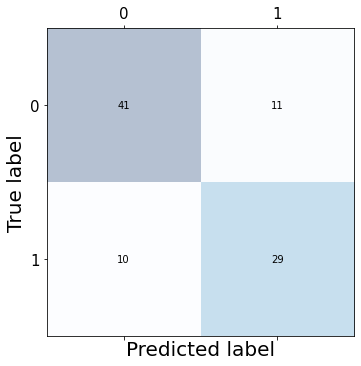

In [10]:
# p = precision_score(y_true=y_test, y_pred=y_pred, average='micro')
# print("Precision_Score:",p)

f = f1_score(y_true=y_test, y_pred=y_pred, average='micro')
print("F1_Score:",f)

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
fig, ax = plt.subplots(figsize=(5,5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
plt.savefig('./output/fig-logistic-regression-confusion-3.png', dpi=300)
plt.show()